# EDA Code

# Preprocessing the Data

In [ ]:
# 1. Install necessary libraries
!pip install plotly --upgrade

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from google.colab import files, drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
# 2. Data Import and Preprocessing
drive.mount('/content/drive')

# Load datasets
df_socio = pd.read_csv("/content/drive/MyDrive/auxiliary_socioeconomic_processed.csv")
df_encounter = pd.read_csv("/content/drive/MyDrive/cleaned_selected_features_2020_2024-newmain.csv")

# Merge datasets on state abbreviation and year
df_encounter['state_abbr'] = df_encounter['state']  # Unify state abbreviation column
df_merged = pd.merge(df_encounter, df_socio, on=['state_abbr', 'year'], how='inner')

# Handle missing values in critical columns
df_merged['race_clean'] = df_merged['race'].fillna('Unknown')  # Race missing -> 'Unknown'
df_merged['armed_with'] = df_merged['armed_with'].fillna('Unknown')  # Weapon type missing -> 'Unknown'
df_merged['gender'] = df_merged['gender'].fillna('Unknown')  # Gender missing -> 'Unknown'

# Fill numerical missing values with 0 (as suggested)
num_cols = ['age', 'poverty_rate', 'high_school_grad_rate', 'median_household_income']
df_merged[num_cols] = df_merged[num_cols].fillna(0)

# Create preventable incidents flag (from original code)
df_merged['is_preventable'] = (
    (df_merged['armed_with'].isin(['unarmed', 'replica'])) |
    (df_merged['was_mental_illness_related'] == True) |
    (df_merged['threat_type'].isin(['flee', 'move', 'undetermined']))
)


Mounted at /content/drive


# Preliminary Data Exploration


In [ ]:
# 1. What is the shape of the DataFrames?
print("\n1. DataFrame Shapes:")
print(f" - Socioeconomic Data: {df_socio.shape}")
print(f" - Encounter Data: {df_encounter.shape}")
print(f" - Merged Data: {df_merged.shape}")
# 2. How many rows and columns do they have?
print("\n2. Rows and Columns:")
print(f" - Socioeconomic Data: {df_socio.shape[0]} rows, {df_socio.shape[1]} columnsss")
print(f" - Encounter Data: {df_encounter.shape[0]} rows, {df_encounter.shape[1]} columns")
print(f" - Merged Data: {df_merged.shape[0]} rows, {df_merged.shape[1]} columns")
# 3. What are the column names?
print("\n3. Column Names:")
print(" - Socioeconomic Data Columns:", df_socio.columns.tolist())
print(" - Encounter Data Columns:", df_encounter.columns.tolist())
print(" - Merged Data Columns:", df_merged.columns.tolist())

# 4. Are there any NaN values or duplicates?
print("\n4. Missing Values Summary:")
print(" - Merged Data Missing Values:")
missing_values = df_merged.isnull().sum()
print(missing_values[missing_values > 0])  # Only show columns with missing values
# 5. Check for Missing Values and Duplicates
print("\n5. Duplicate Rows:")
duplicate_rows = df_merged.duplicated().sum()
print(f" - Number of duplicate rows in merged data: {duplicate_rows}")
# Handle duplicates if any
if duplicate_rows > 0:
    df_merged = df_merged.drop_duplicates()
    print(f" - Removed {duplicate_rows} duplicate rows. New shape: {df_merged.shape}")


1. DataFrame Shapes:
 - Socioeconomic Data: (260, 14)
 - Encounter Data: (5199, 29)
 - Merged Data: (5199, 43)

2. Rows and Columns:
 - Socioeconomic Data: 260 rows, 14 columnsss
 - Encounter Data: 5199 rows, 29 columns
 - Merged Data: 5199 rows, 43 columns

3. Column Names:
 - Socioeconomic Data Columns: ['NAME', 'state_abbr', 'poverty_rate', 'high_school_grad_rate', 'median_household_income', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic', 'share_two_or_more', 'total_population', 'state_code', 'year']
 - Encounter Data Columns: ['threat_type', 'flee_status', 'armed_with', 'city', 'state', 'latitude', 'longitude', 'age', 'gender', 'race', 'was_mental_illness_related', 'body_camera', 'year', 'row_id', 'has_gun', 'has_knife', 'has_blunt_object', 'has_vehicle', 'has_replica', 'has_unarmed', 'has_other', 'race_std', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic', 'share_two_or_more', 'state_abbr']
 - Merged D

# Exploratory  Analysis

**Univariate Analysis:**

/tmp/ipython-input-956039673.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


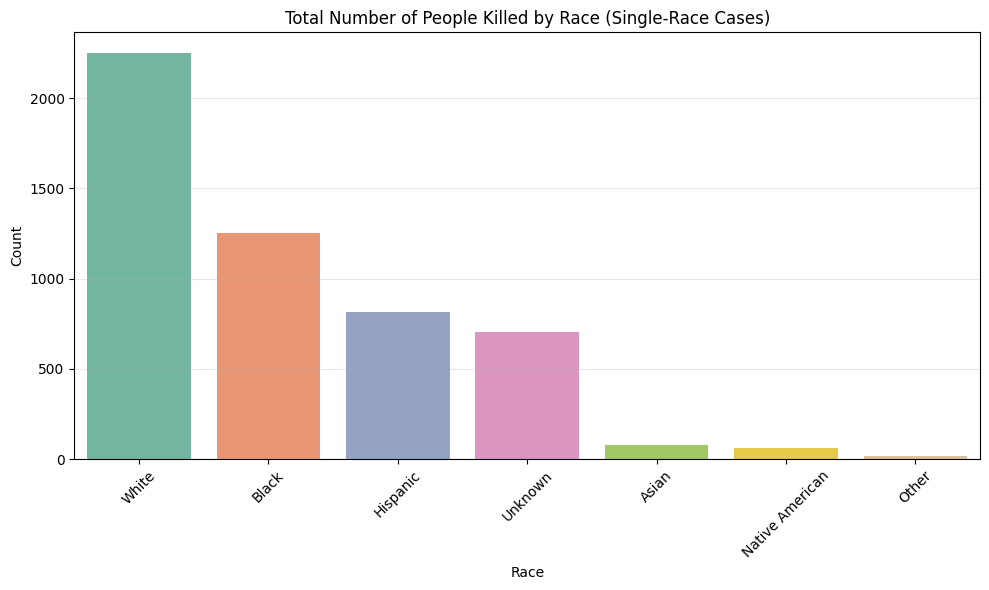

In [ ]:
# 1. Total number of people killed, by race (exclude mixed-race cases)

df_merged["race_clean"] = df_merged["race"].fillna("Unknown")

race_single = df_merged[~df_merged["race_clean"].str.contains(";", na=False)]

race_counts = (
    race_single["race_clean"]
    .value_counts()
    .reset_index()
)

race_counts.columns = ["race", "count"]


race_map = {
    "W": "White",
    "B": "Black",
    "H": "Hispanic",
    "A": "Asian",
    "N": "Native American",
    "O": "Other",
    "Unknown": "Unknown"
}

race_counts["race"] = race_counts["race"].map(race_map)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=race_counts,
    x="race",
    y="count",
    palette="Set2"
)

plt.title("Total Number of People Killed by Race (Single-Race Cases)")
plt.xlabel("Race")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

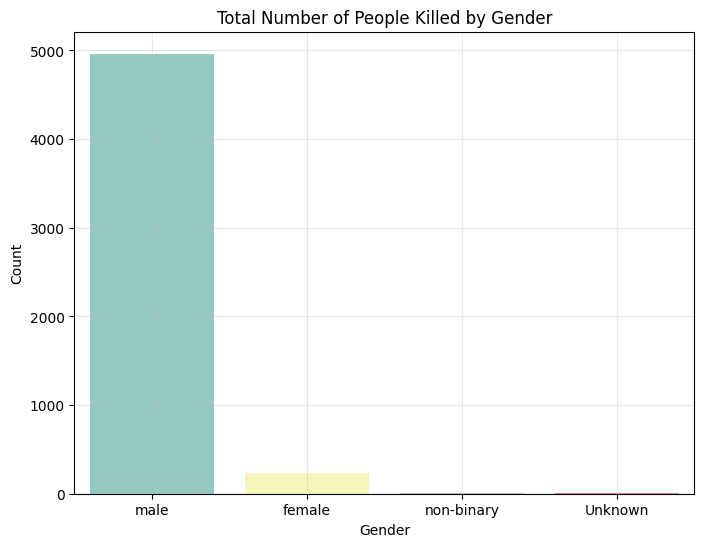

In [ ]:
# 2. Total number of people killed, by gender
gender_counts = df_merged['gender'].value_counts().reset_index()
gender_counts.columns = ['gender', 'count']

plt.figure(figsize=(8, 6))
sns.barplot(
    data=gender_counts,
    x='gender',
    y='count',
    hue='gender',
    palette='Set3',
    legend=False
)
plt.title('Total Number of People Killed by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

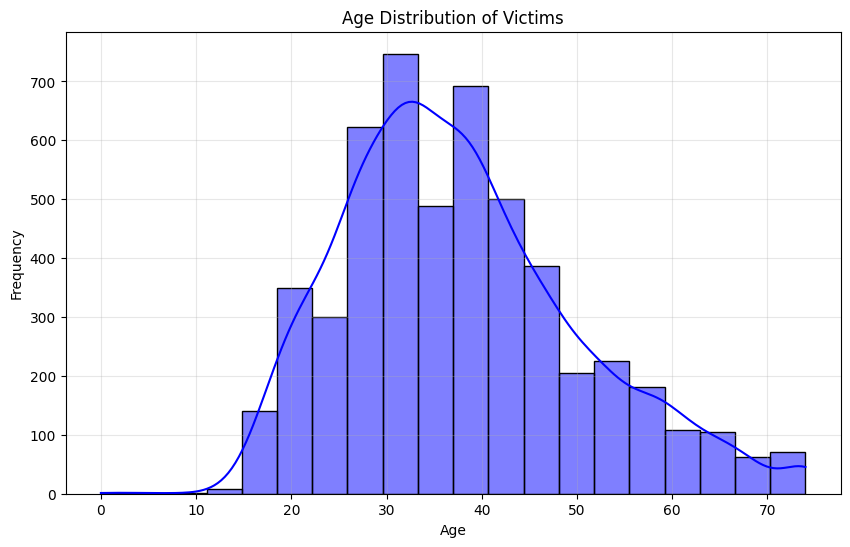

In [ ]:
# 3. General age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution of Victims')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

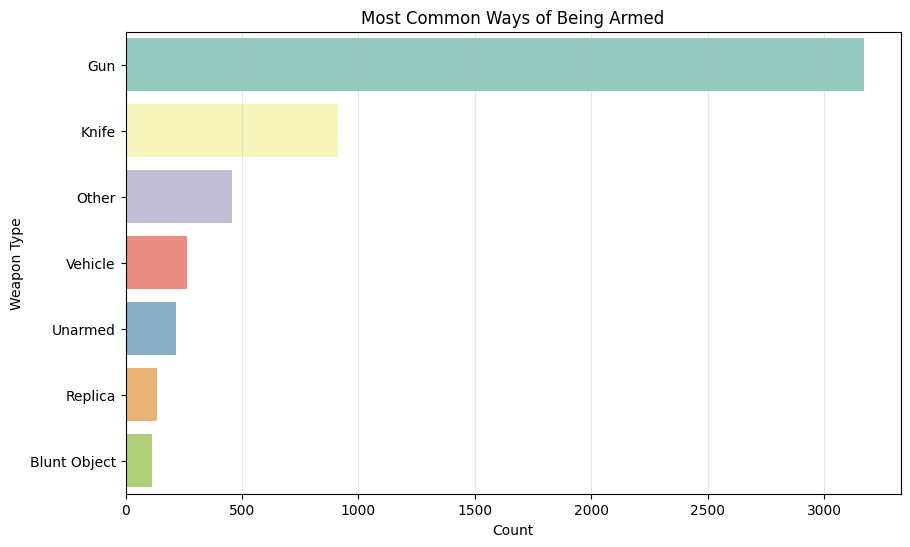

In [ ]:
# 4. Most common ways of being armed

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



weapon_columns = [
    'has_gun',
    'has_knife',
    'has_blunt_object',
    'has_vehicle',
    'has_replica',
    'has_unarmed',
    'has_other'
]


weapon_counts = df_merged[weapon_columns].sum().sort_values(ascending=False).reset_index()
weapon_counts.columns = ['weapon_type', 'count']


weapon_labels = {
    'has_gun': 'Gun',
    'has_knife': 'Knife',
    'has_blunt_object': 'Blunt Object',
    'has_vehicle': 'Vehicle',
    'has_replica': 'Replica',
    'has_unarmed': 'Unarmed',
    'has_other': 'Other'
}
weapon_counts['weapon_type'] = weapon_counts['weapon_type'].map(weapon_labels)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=weapon_counts,
    y='weapon_type',
    x='count',
    hue='weapon_type',
    palette='Set3',
    legend=False
)

plt.title('Most Common Ways of Being Armed')
plt.xlabel('Count')
plt.ylabel('Weapon Type')
plt.grid(axis='x', alpha=0.3)
plt.show()




In [ ]:
# 5. Percentage of people killed with mental illness diagnosis
mental_illness_pct = df_merged['was_mental_illness_related'].mean() * 100
print(f"\n5. Percentage with mental illness diagnosis: {mental_illness_pct:.1f}%")


5. Percentage with mental illness diagnosis: 16.1%


**Bivariate Analysis**

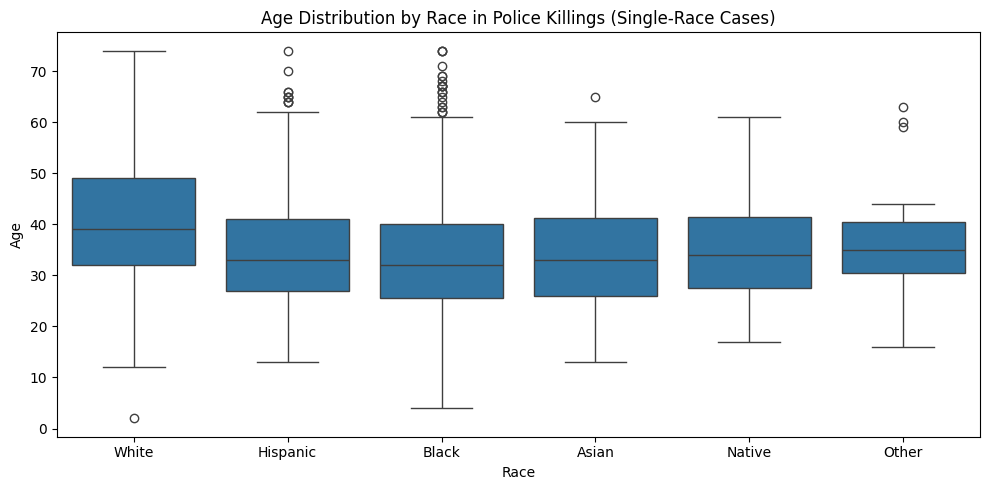

In [ ]:
# 6. Police Use of Force Data - Race and Age Distribution Boxplot Analysis

import seaborn as sns
import matplotlib.pyplot as plt

race_map = {
    "W": "White",
    "B": "Black",
    "H": "Hispanic",
    "A": "Asian",
    "N": "Native",
    "O": "Other",
    "U": "Unknown"
}

age_race_df = (
    df_merged[["race", "age"]]
    .dropna()
    .query("';' not in race")
    .query("race in @race_map.keys()")
    .assign(race_label=lambda x: x["race"].map(race_map))
)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=age_race_df,
    x="race_label",
    y="age"
)

plt.title("Age Distribution by Race in Police Killings (Single-Race Cases)")
plt.xlabel("Race")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

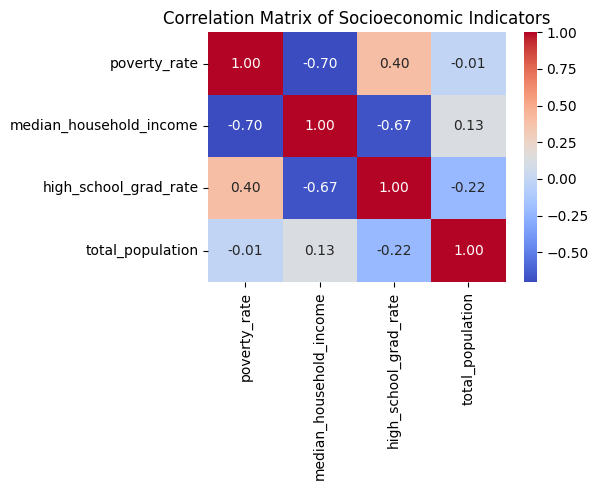

In [ ]:
# 7. Relationship between Poverty Rates and High School Graduation Rates
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

socio_vars = df_socio[
    ["poverty_rate", "median_household_income", "high_school_grad_rate","total_population"]
]

corr_matrix = socio_vars.corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Correlation Matrix of Socioeconomic Indicators")
plt.tight_layout()
plt.show()

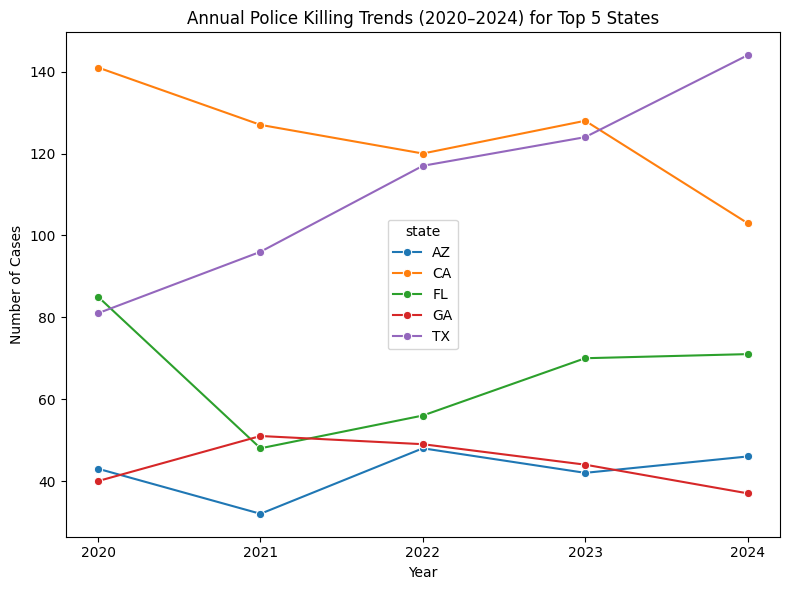

In [ ]:
# 8. analyzing the 2020-2024 annual case count trends for the top 5 U.S. states
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_merged["year"] = df_merged["year"].astype(int)
top_states = df_merged["state"].value_counts().head(5).index
trend_data = (
    df_merged[df_merged["state"].isin(top_states)]
    .groupby(["state", "year"])
    .size()
    .reset_index(name="cases")
    .sort_values(["state", "year"])
)

plt.figure(figsize=(8,6))
sns.lineplot(
    data=trend_data,
    x="year",
    y="cases",
    hue="state",
    marker="o"
)

plt.xticks(sorted(trend_data["year"].unique()))
plt.xlabel("Year")
plt.ylabel("Number of Cases")
plt.title("Annual Police Killing Trends (2020–2024) for Top 5 States")
plt.tight_layout()
plt.show()

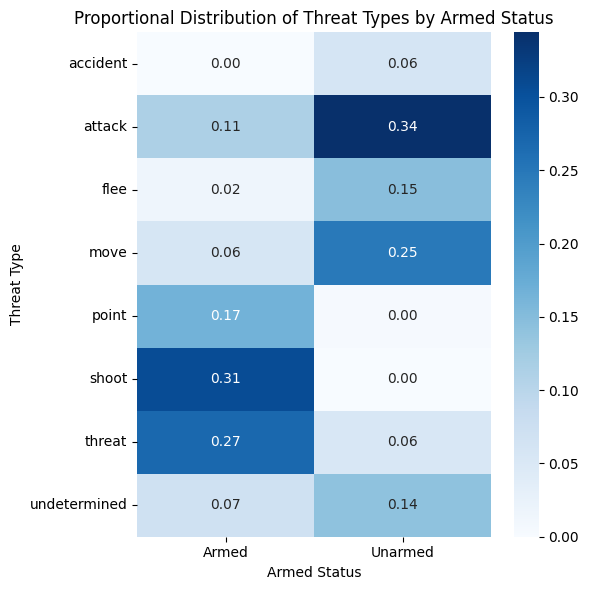

In [ ]:
# 9. Analysis of Threat Type Distribution: Unarmed vs Armed Cases

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# 1. grouping armed——status
weapon_cols = [
    "has_gun",
    "has_knife",
    "has_blunt_object",
    "has_vehicle",
    "has_replica",
    "has_other"
]

df_merged["armed_status"] = df_merged[weapon_cols].max(axis=1)
df_merged["armed_status"] = df_merged["armed_status"].map({1: "Armed", 0: "Unarmed"})

# 2. Calculate the proportion of threat_type within each armed_status
threat_prop = (
    df_merged.groupby("armed_status")["threat_type"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
)

# 3. Heatmap visualization
plt.figure(figsize=(6,6))
sns.heatmap(
    threat_prop.T,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)

plt.xlabel("Armed Status")
plt.ylabel("Threat Type")
plt.title("Proportional Distribution of Threat Types by Armed Status")
plt.tight_layout()
plt.show()

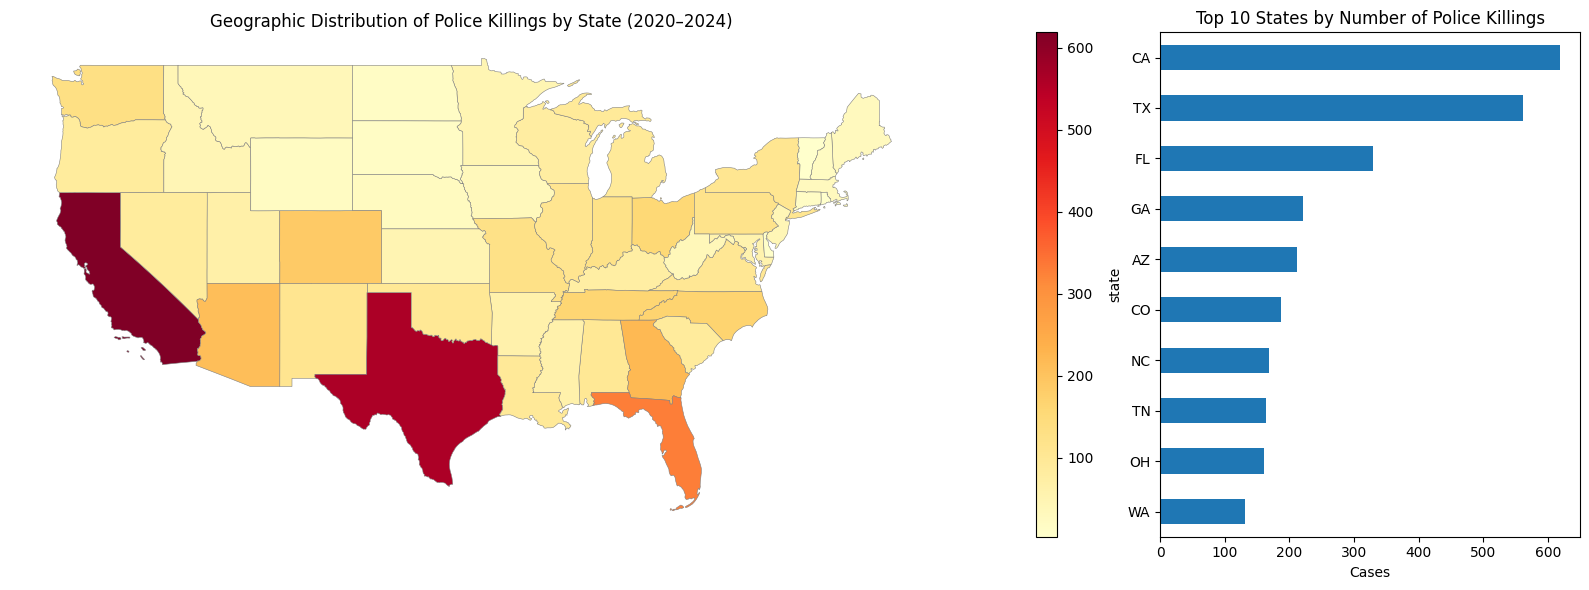

In [ ]:
# 10. Number of police killings, by state
import pandas as pd
import plotly.express as px
from google.colab import files
import geopandas as gpd

# Load US states shapefile (Census)
us_states = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
)
contiguous_states = us_states[
    ~us_states["STUSPS"].isin(["AK", "HI", "PR", "VI", "GU", "MP", "AS"])
]

state_counts = df_merged["state"].value_counts().rename("cases")

map_df = contiguous_states.merge(
    state_counts,
    left_on="STUSPS",
    right_index=True,
    how="left"
).fillna(0)

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 3, width_ratios=[2.2, 0.05, 1], figure=fig)

ax_map = fig.add_subplot(gs[0, 0])
ax_cbar = fig.add_subplot(gs[0, 1])
ax_bar = fig.add_subplot(gs[0, 2])

# Map
map_df.plot(
    column="cases",
    cmap="YlOrRd",
    linewidth=0.4,
    edgecolor="0.5",
    legend=True,
    cax=ax_cbar,
    ax=ax_map
)

ax_map.set_title("Geographic Distribution of Police Killings by State (2020–2024)")
ax_map.axis("off")

# Bar chart
state_counts.head(10).sort_values().plot(
    kind="barh",
    ax=ax_bar
)
ax_bar.set_title("Top 10 States by Number of Police Killings")
ax_bar.set_xlabel("Cases")

plt.tight_layout()
plt.show()


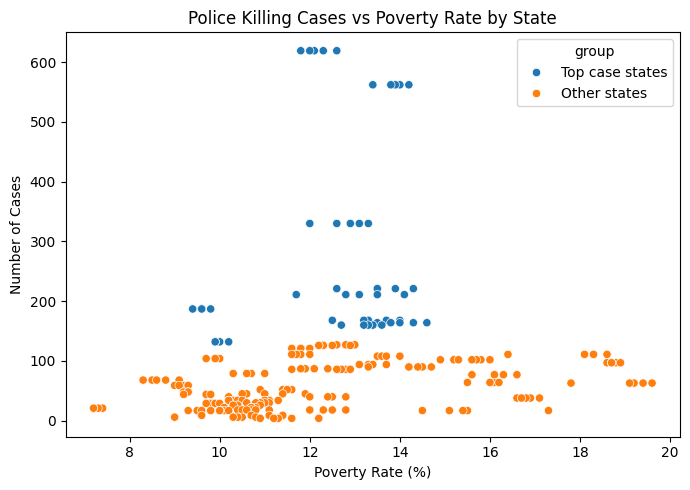

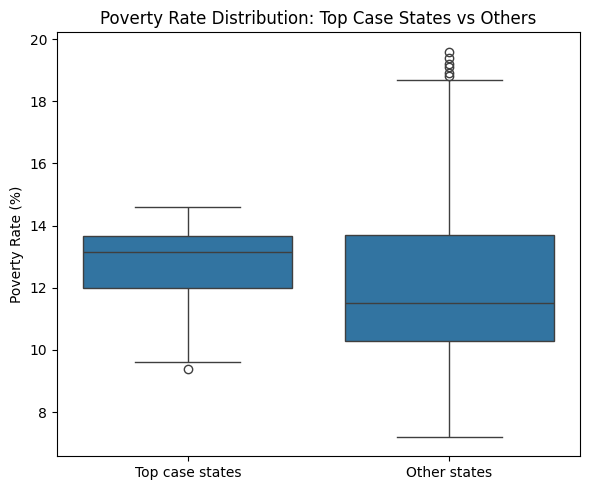

In [ ]:
# 11.The distribution of Poverty Rate among Top cases states & other states

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

socio_df = pd.read_csv("/content/drive/MyDrive/auxiliary_socioeconomic_processed.csv")

state_counts = (
    df_merged["state"]
    .value_counts()
    .reset_index()
)

state_counts.columns = ["state", "case_count"]

top_states = (
    state_counts
    .sort_values("case_count", ascending=False)
    .head(10)["state"]
    .tolist()
)
state_counts = state_counts.rename(columns={"state_abbr": "state"})
socio_df = socio_df.rename(columns={"state_abbr": "state"})

analysis_df = (
    state_counts
    .merge(
        socio_df,
        on="state",
        how="left"
    )
)

analysis_df["group"] = analysis_df["state"].isin(top_states)
analysis_df["group"] = analysis_df["group"].map(
    {True: "Top case states", False: "Other states"}
)

plt.figure(figsize=(7, 5))

sns.scatterplot(
    data=analysis_df,
    x="poverty_rate",
    y="case_count",
    hue="group"
)

plt.title("Police Killing Cases vs Poverty Rate by State")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Number of Cases")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))

sns.boxplot(
    data=analysis_df,
    x="group",
    y="poverty_rate"
)

plt.title("Poverty Rate Distribution: Top Case States vs Others")
plt.xlabel("")
plt.ylabel("Poverty Rate (%)")
plt.tight_layout()
plt.show()

**Multivariate Analysis**

In [ ]:
# 12.The correlation between race/metal/body camera/armed status
df_merged["race_filled"] = df_merged["race"].fillna("Missing")
race_groups = ["W", "B", "H", "A", "N", "Missing"]
for r in race_groups:
    print(f"\nRace = {r}")
    display(
        pd.crosstab(
            [df_merged[df_merged["race_filled"] == r]["was_mental_illness_related"],
             df_merged[df_merged["race_filled"] == r]["body_camera"]],
            df_merged[df_merged["race_filled"] == r]["armed_status"],
            normalize="index"
        )
    )




Race = W


armed_status                               Armed   Unarmed
was_mental_illness_related body_camera                    
False                      False        0.968643  0.031357
                           True         0.950617  0.049383
True                       False        0.954054  0.045946
                           True         0.945055  0.054945


Race = B


armed_status                               Armed   Unarmed
was_mental_illness_related body_camera                    
False                      False        0.955671  0.044329
                           True         0.916933  0.083067
True                       False        0.971429  0.028571
                           True         0.914286  0.085714


Race = H


armed_status                               Armed   Unarmed
was_mental_illness_related body_camera                    
False                      False        0.955117  0.044883
                           True         0.940120  0.059880
True                       False        0.924242  0.075758
                           True         0.923077  0.076923


Race = A


armed_status                               Armed   Unarmed
was_mental_illness_related body_camera                    
False                      False        0.976744  0.023256
                           True         1.000000  0.000000
True                       False        1.000000  0.000000
                           True         1.000000  0.000000


Race = N


armed_status                               Armed   Unarmed
was_mental_illness_related body_camera                    
False                      False        0.909091  0.090909
                           True         0.916667  0.083333
True                       False        1.000000  0.000000
                           True         1.000000  0.000000


Race = Missing


armed_status                               Armed   Unarmed
was_mental_illness_related body_camera                    
False                      False        0.962818  0.037182
                           True         0.956522  0.043478
True                       False        1.000000  0.000000
                           True         1.000000  0.000000

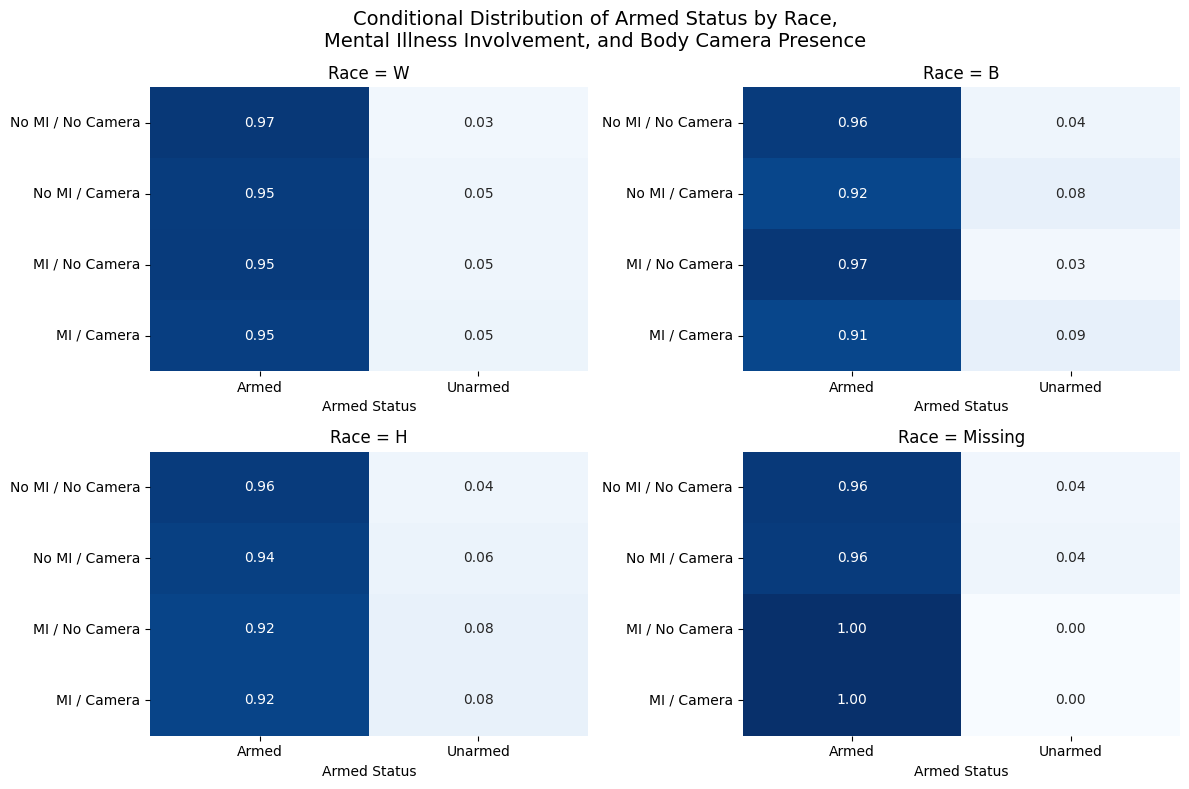

In [ ]:
# 12.The correlation between race/metal/body camera/armed status（for report visualization)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_conditional_heatmap(df, race_code, ax):
    sub = df[df["race_filled"] == race_code]

    tab = pd.crosstab(
        index=[sub["was_mental_illness_related"], sub["body_camera"]],
        columns=sub["armed_status"],
        normalize="index"
    )


    tab = tab.reindex(
        index=[(False, False), (False, True), (True, False), (True, True)]
    )

    tab.index = [
        "No MI / No Camera",
        "No MI / Camera",
        "MI / No Camera",
        "MI / Camera"
    ]

    sns.heatmap(
        tab,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        vmin=0,
        vmax=1,
        cbar=False,
        ax=ax
    )

    ax.set_title(f"Race = {race_code}")
    ax.set_xlabel("Armed Status")
    ax.set_ylabel("")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

races_to_plot = ["W", "B", "H", "Missing"]

for ax, race in zip(axes.flatten(), races_to_plot):
    plot_conditional_heatmap(df_merged, race, ax)

fig.suptitle(
    "Conditional Distribution of Armed Status by Race,\nMental Illness Involvement, and Body Camera Presence",
    fontsize=14
)

plt.tight_layout()
plt.show()